# High Mountain Asia UCLA Daily Snow Reanalysis, Version 1
Snowpack plays a significant role in the hydrologic cycle over High Mountain Asia (HMA). As a vital water resource, the distribution of snowpack volume also impacts the water availability for downstream populations. To assess the regional water balance, it is important to characterize the spatio-temporal distribution of water storage in the HMA snowpack.
This HMA snow reanalysis data set contains daily estimates of posterior snow water equivalent (SWE), fractional snow covered area (fSCA), snow depth (SD), etc.

https://nsidc.org/data/HMA_SR_D/versions/1

/!\ non seasonal snow may be not reliable because of snow scheme /!\

Stats:  ensemble mean, ensemble standard deviation, ensemble median, 25th percentile, and 75th percentile

Download 24/06/2021

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Try with one tile (1°x1°)

In [2]:
path = '/home/lalandmi/Dropbox/data/HMA_UCLA_Reanalysis/'

In [3]:
ds = xr.open_dataset(path+'5000001147190/210524848/HMA_SR_D_v01_N36_0E74_0_agg_16_WY1999_00_SD_POST.nc')
ds

<xarray.Dataset>
Dimensions:    (Day: 366, Latitude: 225, Longitude: 225, Stats: 5)
Coordinates:
  * Latitude   (Latitude) float32 36.997776 36.993332 ... 36.006737 36.002293
  * Longitude  (Longitude) float32 74.00222 74.00667 ... 74.99411 74.99856
Dimensions without coordinates: Day, Stats
Data variables:
    SD_Post    (Day, Stats, Longitude, Latitude) float32 ...

### Check data

In [4]:
# ds = xr.open_mfdataset('/home/lalandmi/Dropbox/data/HMA_UCLA_Reanalysis/5000001147190/*/HMA_SR_D_v01_N*E*_agg_16_WY1999_00_SD_POST.nc')
ds = xr.open_dataset(path+'5000001147190/210524848/HMA_SR_D_v01_N36_0E74_0_agg_16_WY1999_00_FORCING_POST.nc')
ds

<xarray.Dataset>
Dimensions:    (Day: 366, Latitude: 225, Longitude: 225)
Coordinates:
  * Latitude   (Latitude) float32 36.997776 36.993332 ... 36.006737 36.002293
  * Longitude  (Longitude) float32 74.00222 74.00667 ... 74.99411 74.99856
Dimensions without coordinates: Day
Data variables:
    Ta_Post    (Day, Longitude, Latitude) float32 ...
    Rs_Post    (Day, Longitude, Latitude) float32 ...
    Rl_Post    (Day, Longitude, Latitude) float32 ...
    Ps_Post    (Day, Longitude, Latitude) float32 ...
    PPT_Post   (Day, Longitude, Latitude) float32 ...
    q_Post     (Day, Longitude, Latitude) float32 ...

### Check mask

In [5]:
# ds = xr.open_mfdataset('/home/lalandmi/Dropbox/data/HMA_UCLA_Reanalysis/5000001147190/*/HMA_SR_D_v01_N*E*_agg_16_WY1999_00_SD_POST.nc')
ds = xr.open_dataset(path+'5000001147190/210524848/HMA_SR_D_v01_N36_0E74_0_agg_16_WY1999_00_MASK.nc')
ds

<xarray.Dataset>
Dimensions:                 (Latitude: 225, Longitude: 225, Water_Year: 18)
Coordinates:
  * Longitude               (Longitude) float32 74.00222 74.00667 ... 74.99856
  * Latitude                (Latitude) float32 36.997776 36.993332 ... 36.002293
  * Water_Year              (Water_Year) float64 2e+03 2.001e+03 ... 2.017e+03
Data variables:
    Classification_mask     (Water_Year, Longitude, Latitude) float32 ...
    Non_seasonal_snow_mask  (Longitude, Latitude) float32 ...

The classification mask provided in the mask file contains indicators of whether prior
simulation or posterior update was performed within a certain pixel/year. Three types of
classification were used:

- a. Type 1 for pixels without prior simulation. Pixels are identified as either water
bodies or non-snowy pixels (with negligible snowfall in the nominal simulation).
Prior simulations were skipped in those pixels and all output values equal to zero
(e.g. SWE, fSCA, SD, forcings, etc.).
- b. Type 2 for pixels with prior simulation but no posterior update. These are pixels
where the observed fSCA did not effectively change the prior simulation results
during the data assimilation step. It is usually due to insufficient number of fSCA
measurements or very intermittent snow; and therefore, their posterior outputs
equal the prior.
- c. Type 3 for pixels with prior simulation and posterior update. They are identified as
snowy pixels and received a substantial posterior update during the assimilation
step.

The majority of pixels in this data set are classified as type 3, while the cases of type 1 or
type 2 are relatively rare.

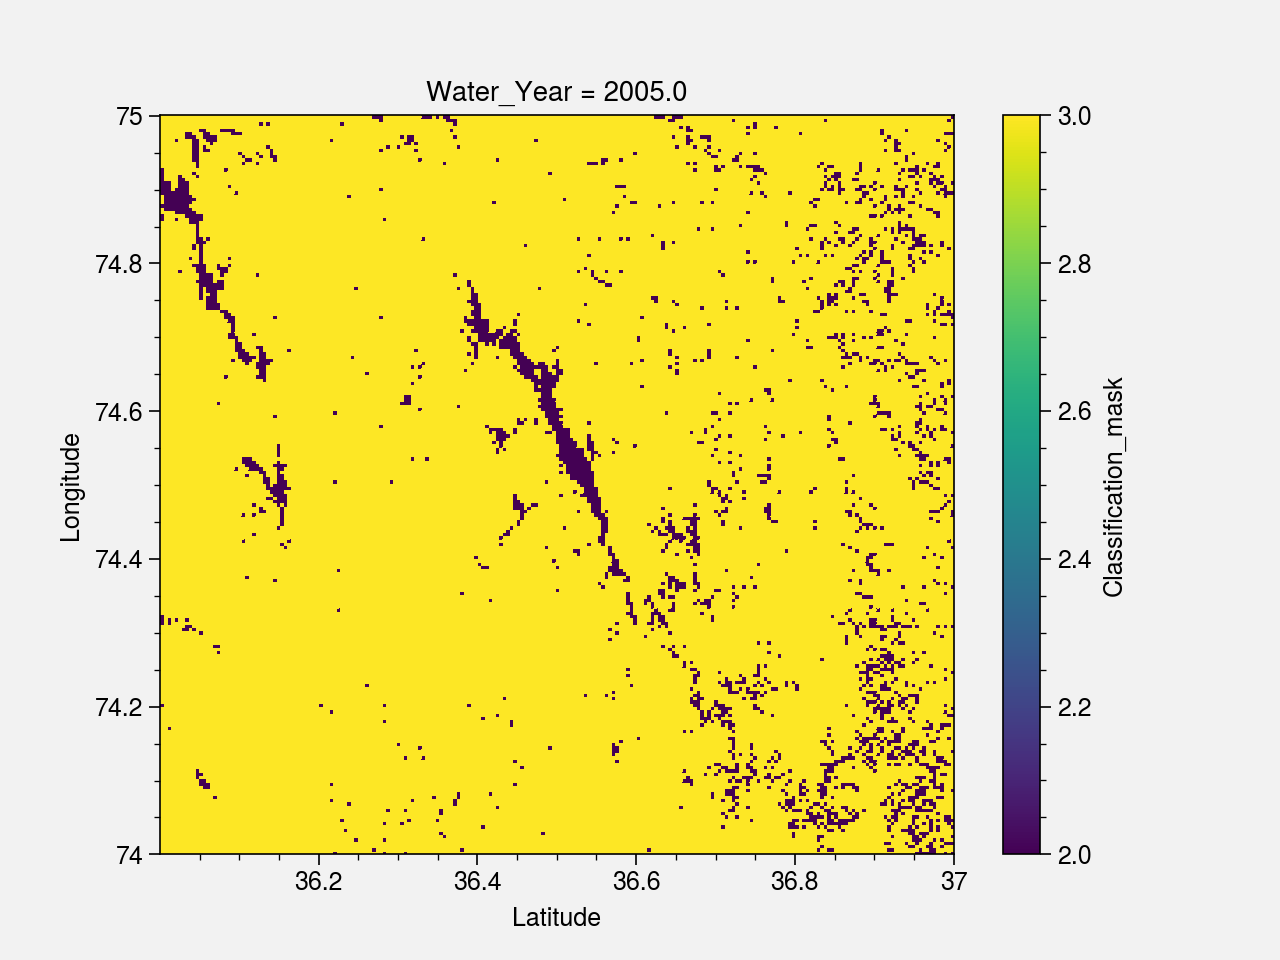

In [6]:
ds.Classification_mask[5].plot()

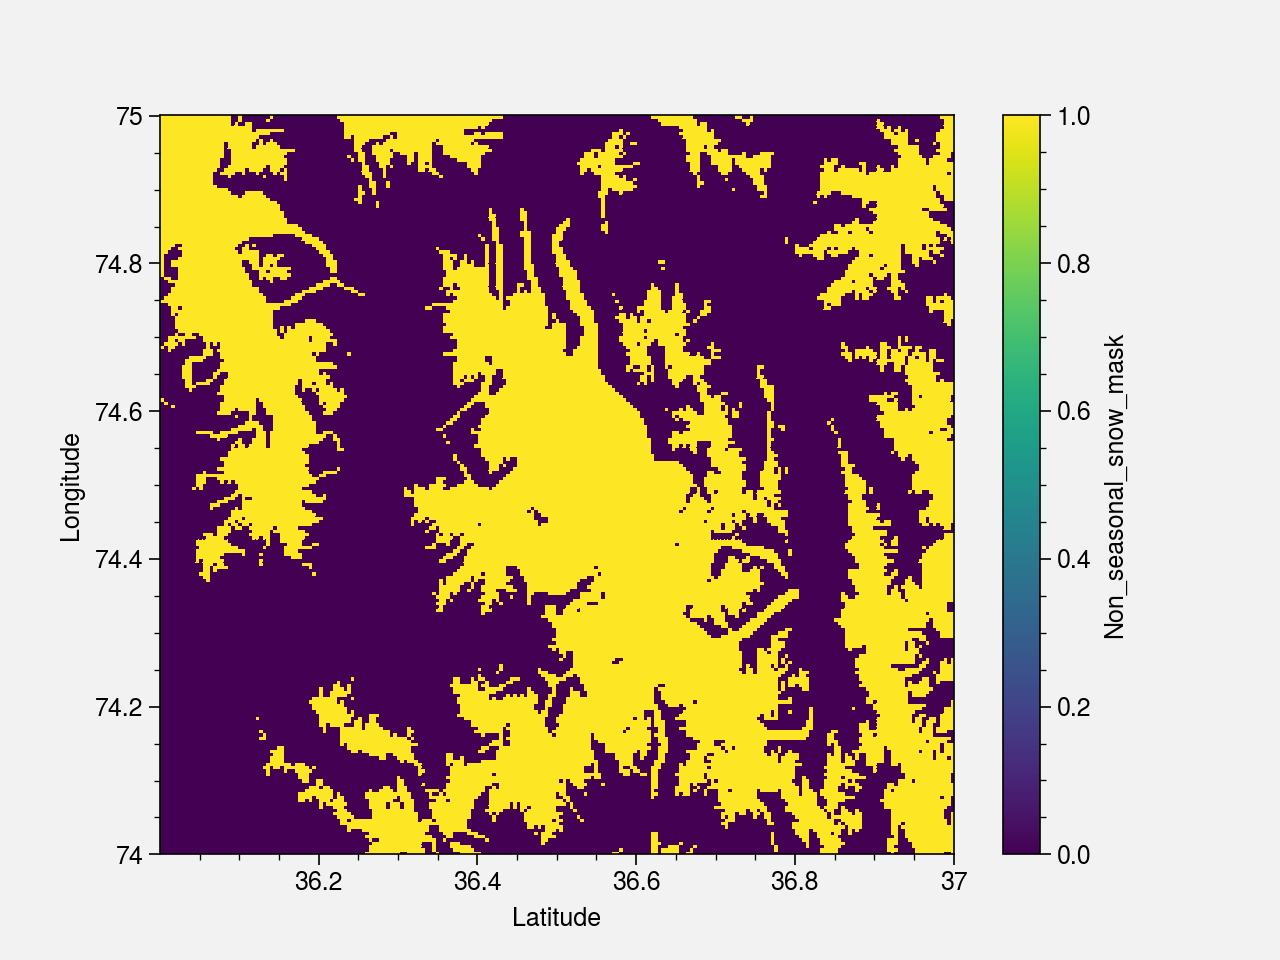

In [7]:
ds.Non_seasonal_snow_mask.plot()

### Load sd, swe and sca

In [8]:
# ds = xr.open_mfdataset('/home/lalandmi/Dropbox/data/HMA_UCLA_Reanalysis/5000001147190/*/HMA_SR_D_v01_N*E*_agg_16_WY1999_00_SD_POST.nc')
ds = xr.open_dataset(path+'5000001147190/210524848/HMA_SR_D_v01_N36_0E74_0_agg_16_WY1999_00_SD_POST.nc')
sd = ds.SD_Post.isel(Stats=0).rename({'Longitude': 'lon', 'Latitude': 'lat'})

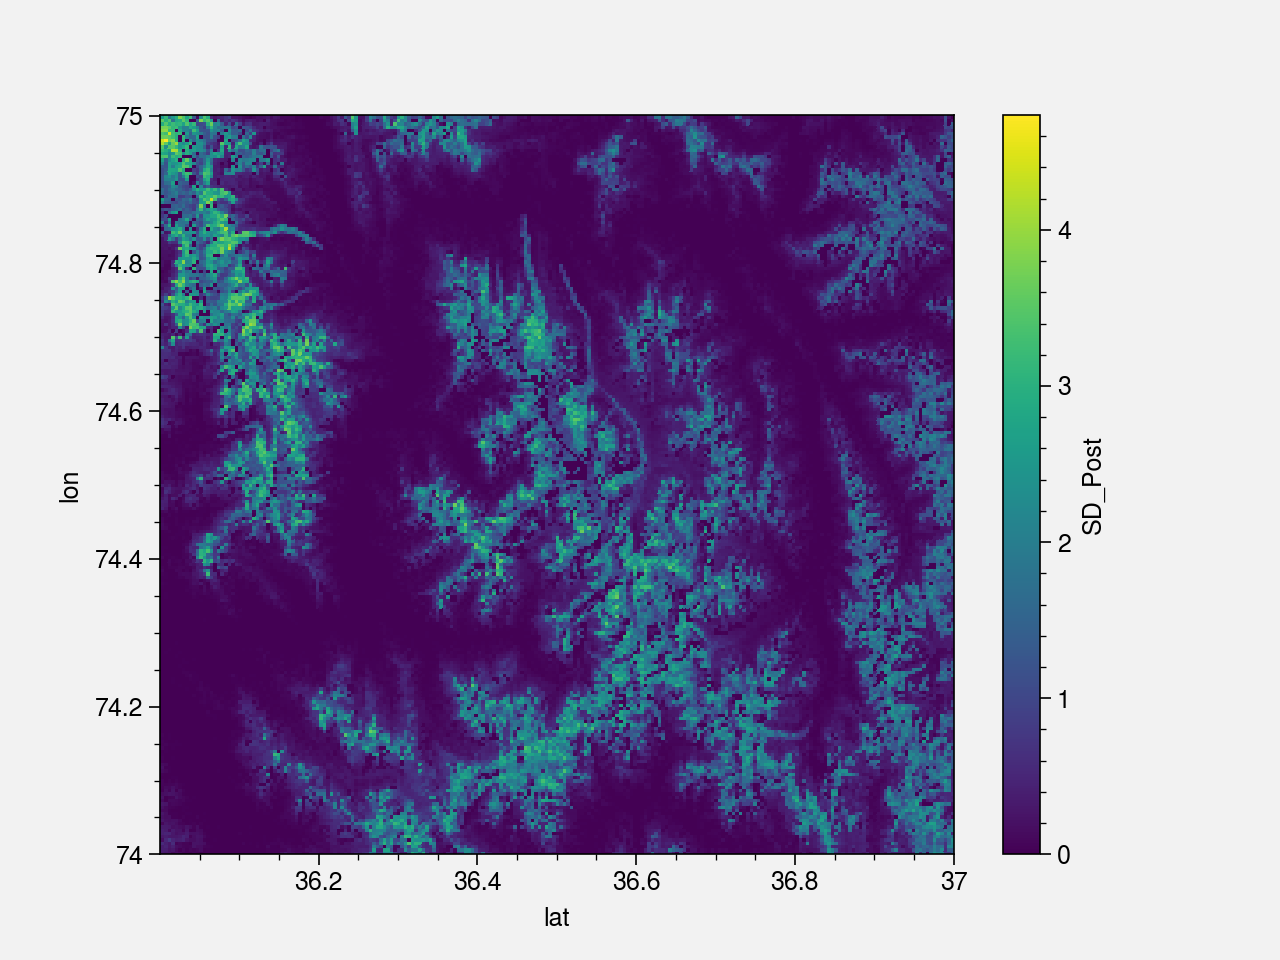

In [9]:
sd.mean('Day').plot()

In [10]:
# ds = xr.open_mfdataset('/home/lalandmi/Dropbox/data/HMA_UCLA_Reanalysis/5000001147190/*/HMA_SR_D_v01_N*E*_agg_16_WY1999_00_SWE_SCA_POST.nc')
ds = xr.open_dataset(path+'5000001147190/210524848/HMA_SR_D_v01_N36_0E74_0_agg_16_WY1999_00_SWE_SCA_POST.nc')
swe = ds.SWE_Post.isel(Stats=0).rename({'Longitude': 'lon', 'Latitude': 'lat'})
sca = ds.SCA_Post.isel(Stats=0).rename({'Longitude': 'lon', 'Latitude': 'lat'})

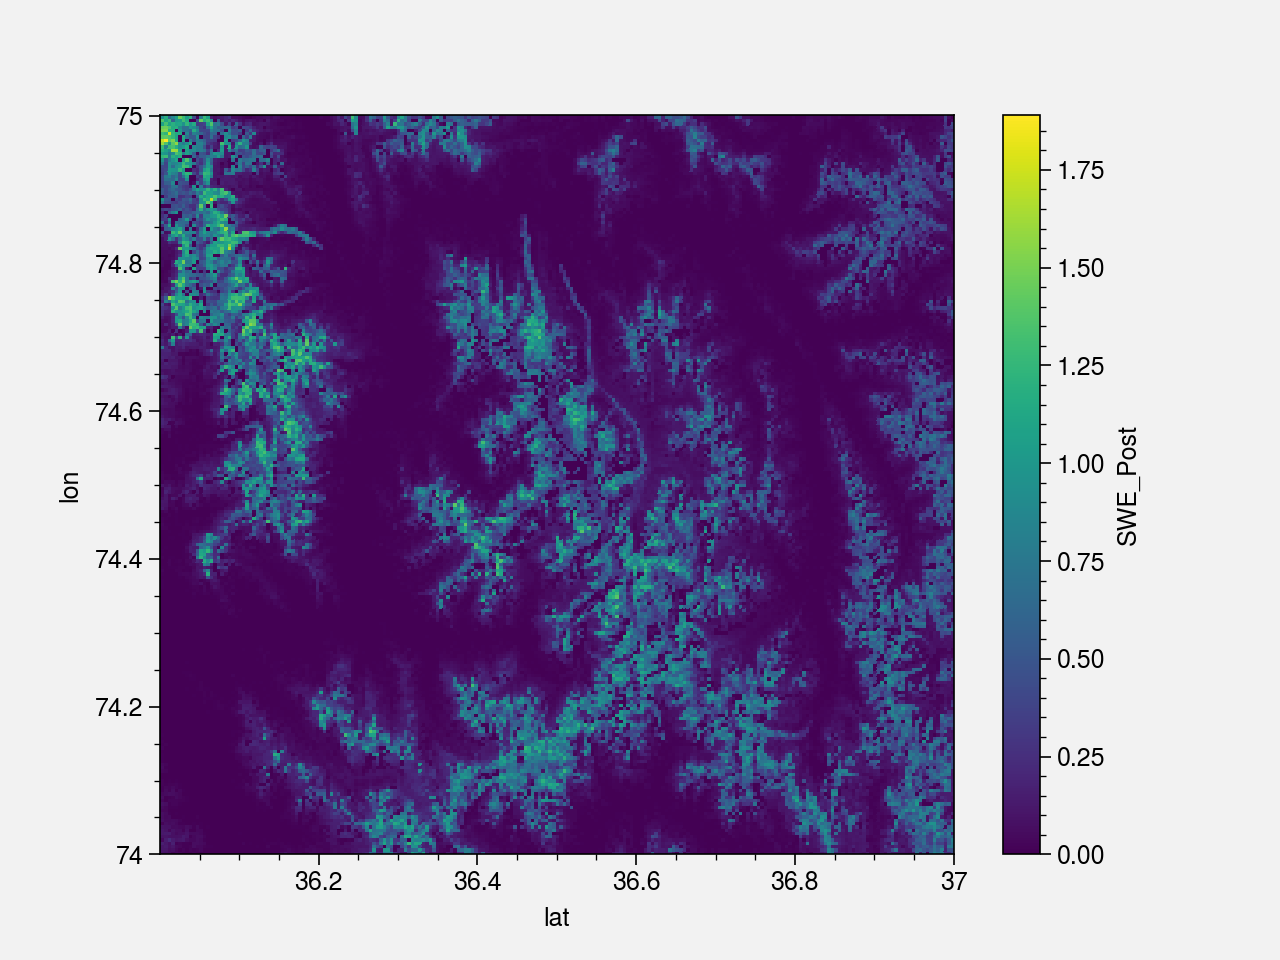

In [11]:
swe.mean('Day').plot()

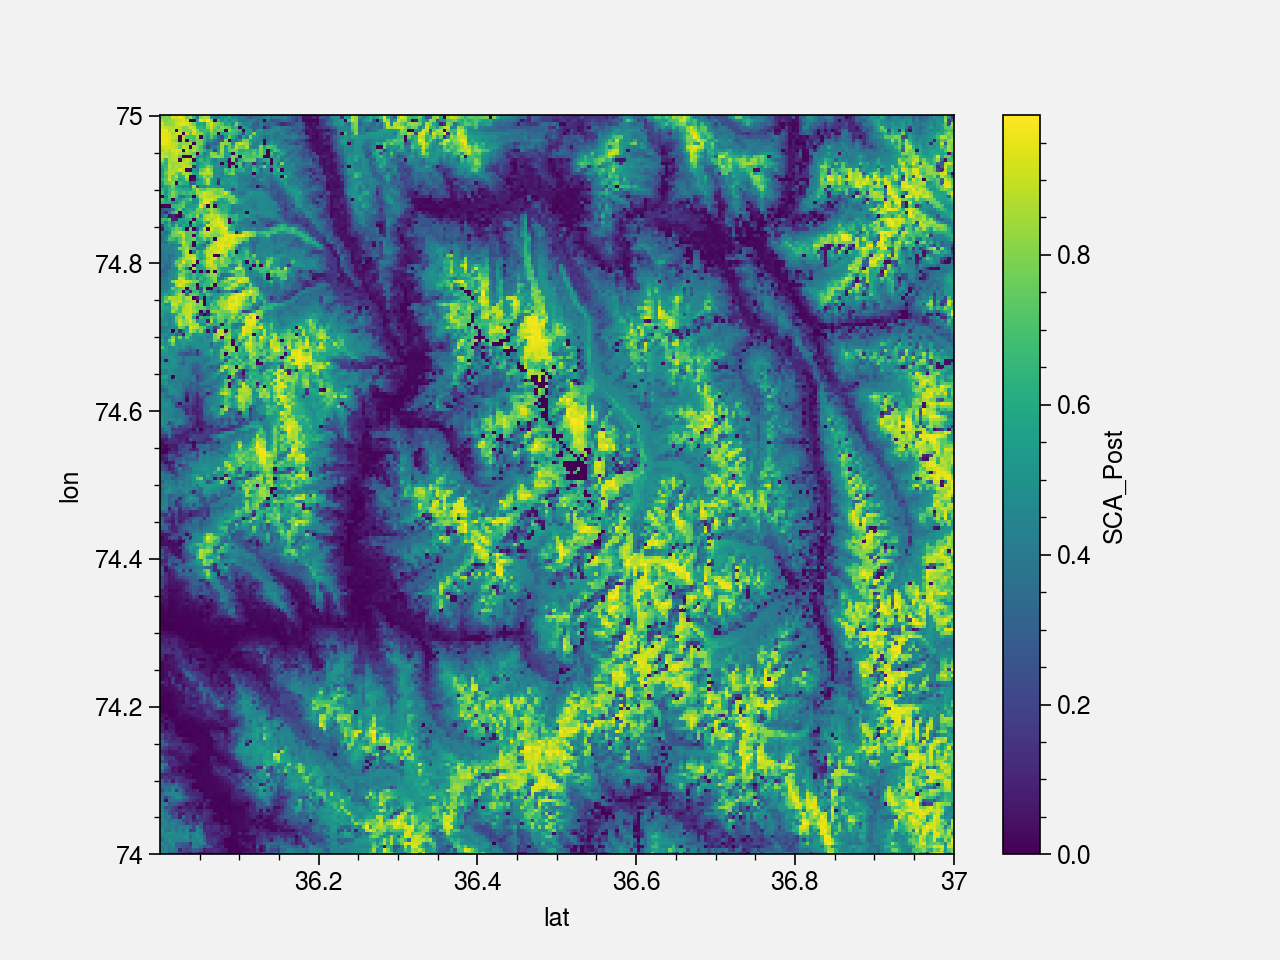

In [12]:
# Des valeurs bizarres à 0... probablement du à la classification 1 et/ou endroits de non seasonal snow
# Je vais tout garder mais à garder en tête que c'est pas parfait et qu'il y a des artefacts !
sca.mean('Day').plot()

### Coarsen values to 0.2° (~20km)

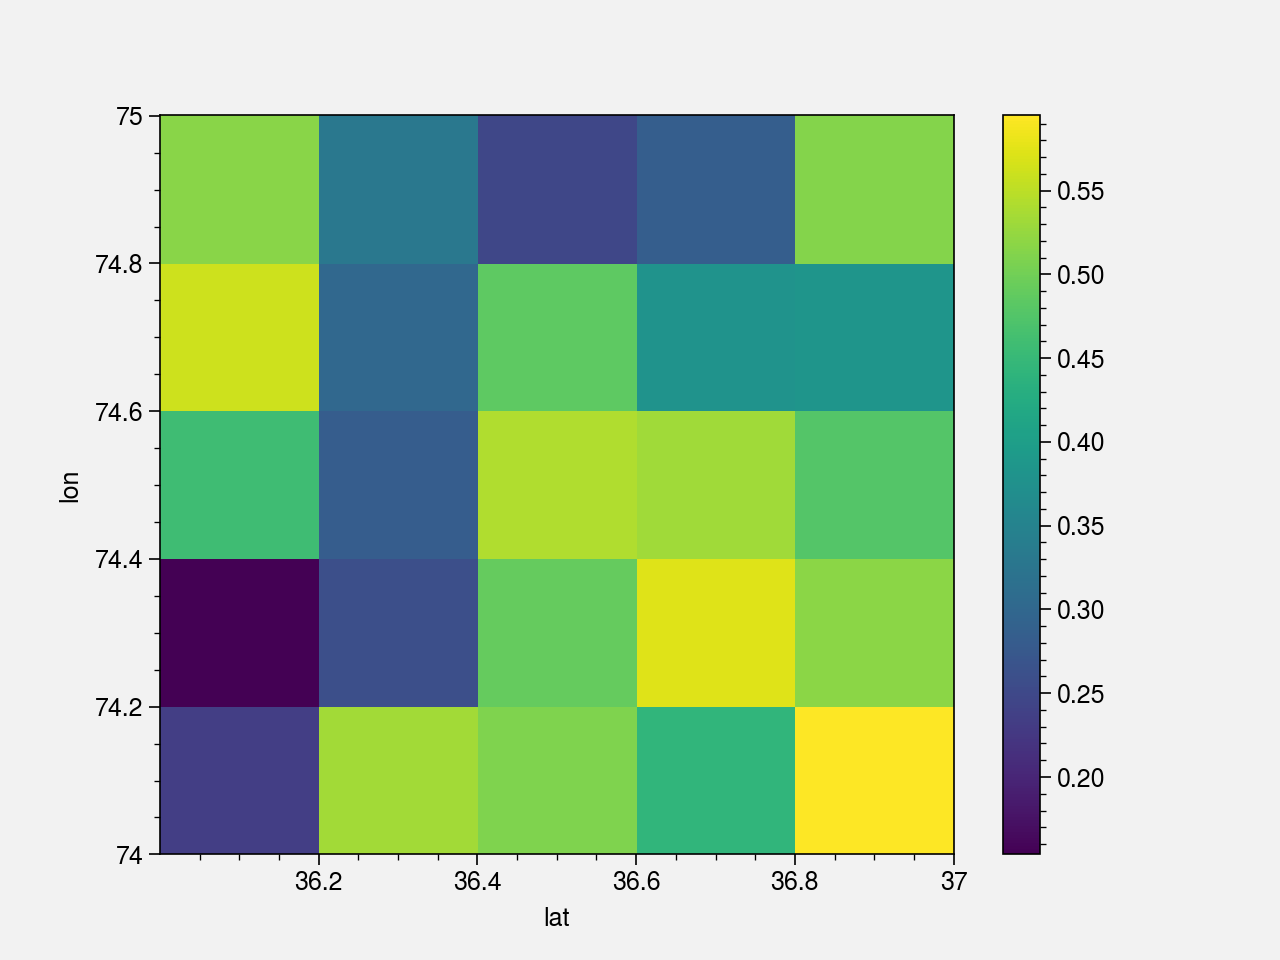

In [13]:
sca.coarsen(lat=45, lon=45).mean().mean('Day').plot()

In [14]:
sd_20km = sd.coarsen(lat=45, lon=45).mean()
swe_20km = swe.coarsen(lat=45, lon=45).mean()
sca_20km = sca.coarsen(lat=45, lon=45).mean()

## Load topo 
Attention les lat/lon sont inversées dans la réanalyse

In [15]:
latlim, lonlim = u.get_domain_HMA()
root_data_path = '/home/lalandmi/Dropbox/data/' # local
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

ds = xr.open_dataset(root_data_path+'GMTED2010/GMTED2010_15n060_0250deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

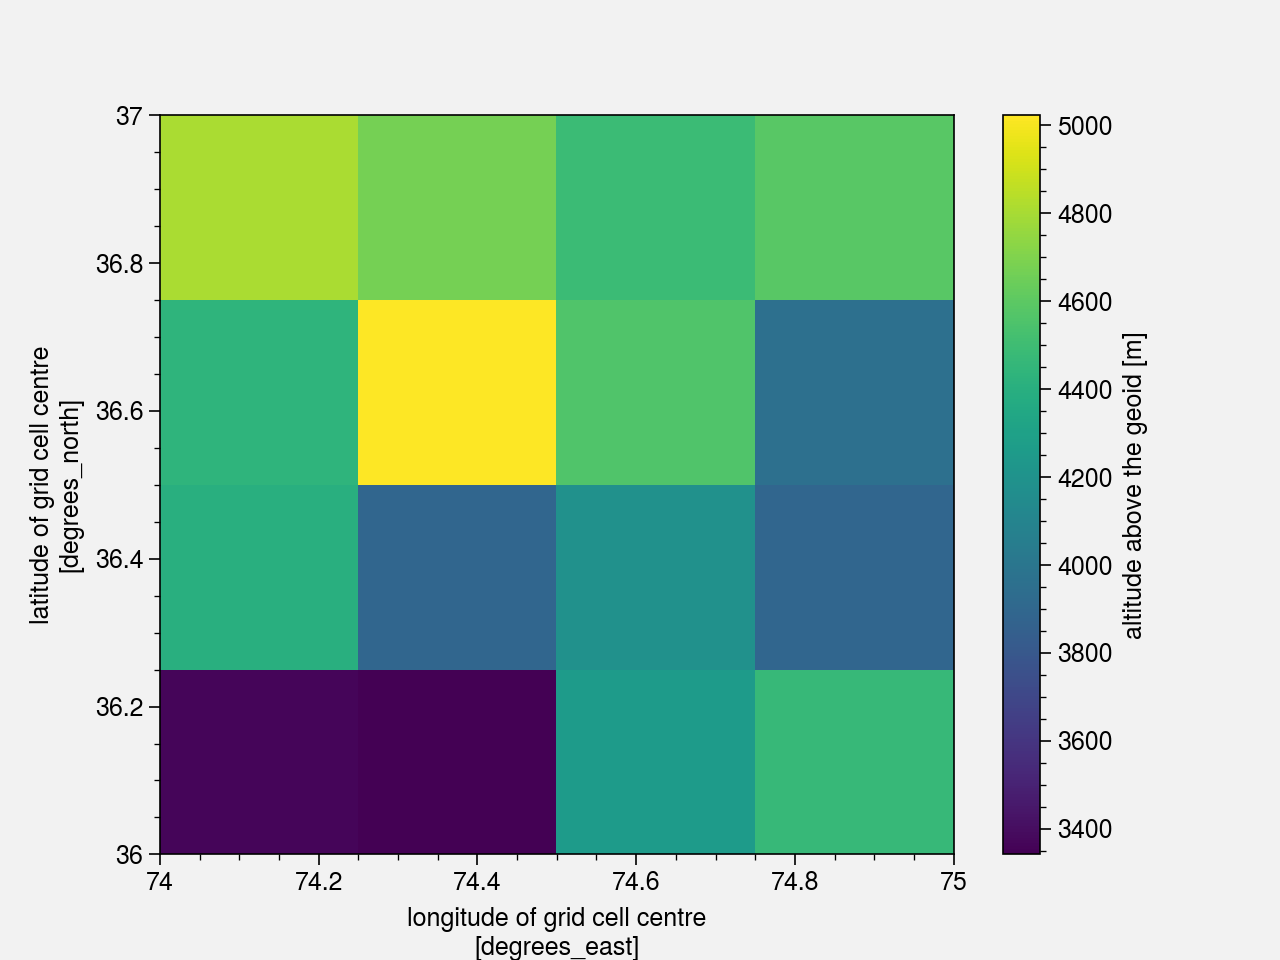

In [16]:
elevation.sel(lon=slice(sd.lon.min(),sd.lon.max()), lat=slice(sd.lat.min(),sd.lat.max())).plot()

In [17]:
elevation_subset = elevation.sel(lon=slice(sd.lon.min(),sd.lon.max()), lat=slice(sd.lat.min(),sd.lat.max()))

## Regrid

In [18]:
regridder = xe.Regridder(sd_20km, elevation_subset, 'bilinear', periodic=False, reuse_weights=True)
sd_regrid = regridder(sd_20km)
swe_regrid = regridder(swe_20km)
sca_regrid = regridder(sca_20km)

Reuse existing file: bilinear_5x5_4x4.nc


## Check SCA/SWE relationship

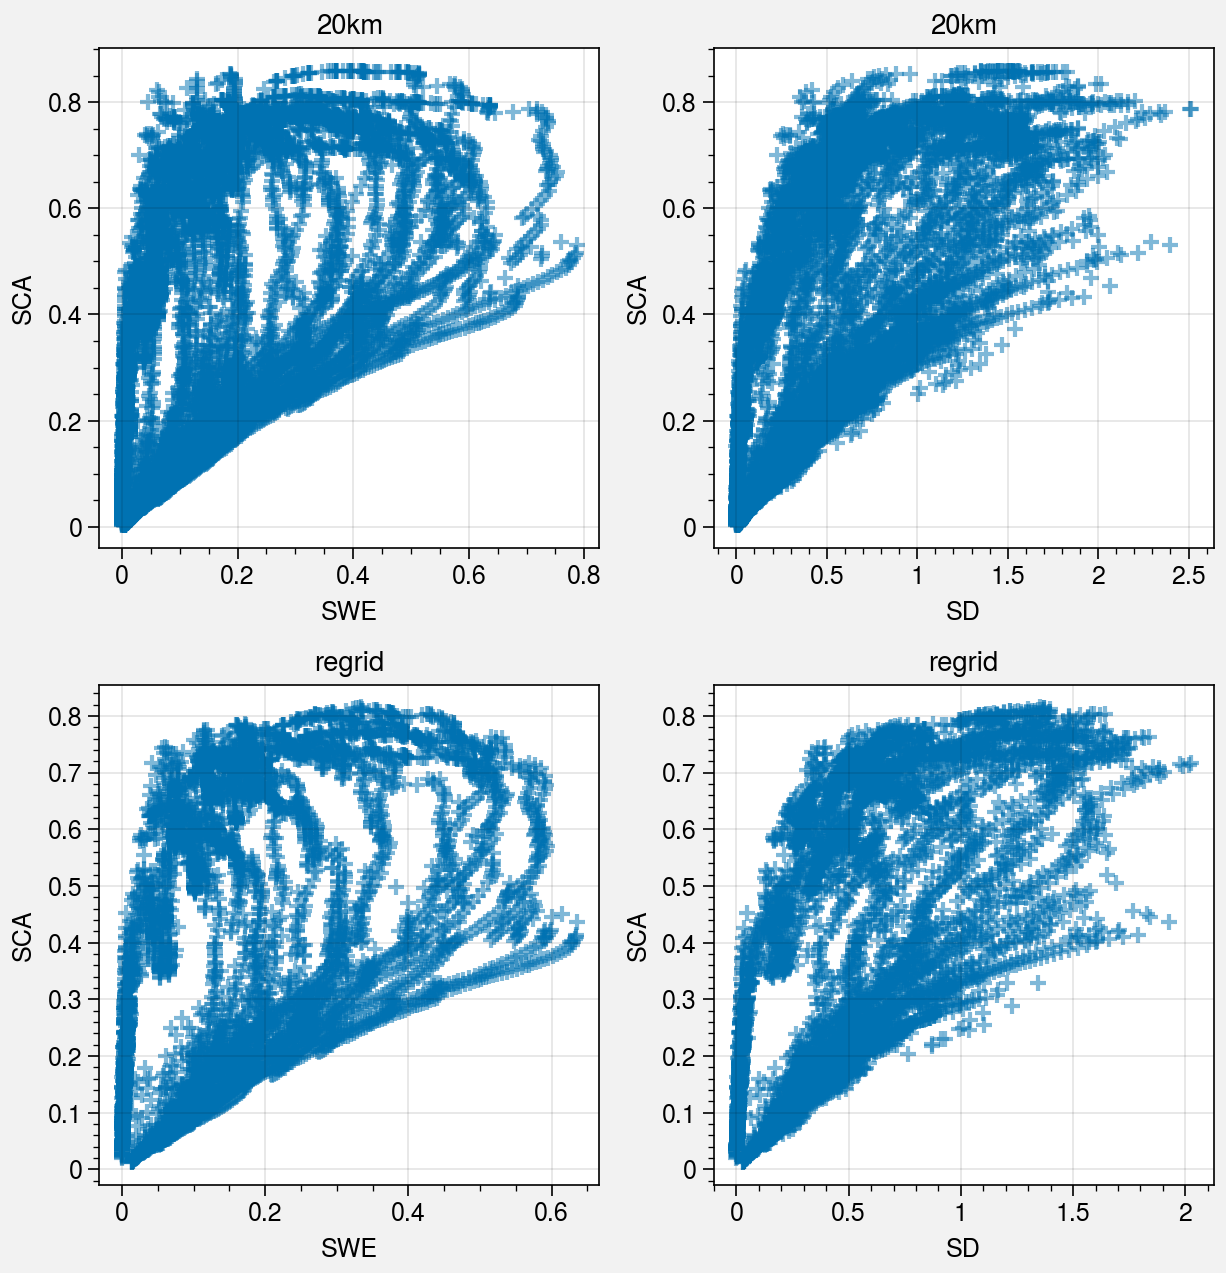

In [19]:
fig, axs = plot.subplots(ncols=2, nrows=2, share=0)

axs[0].scatter(swe_20km.values.flatten(), sca_20km.values.flatten(), marker='+', alpha=0.5)
axs[0].format(xlabel='SWE', ylabel='SCA', title='20km')

axs[1].scatter(sd_20km.values.flatten(), sca_20km.values.flatten(), marker='+', alpha=0.5)
axs[1].format(xlabel='SD', ylabel='SCA', title='20km')

axs[2].scatter(swe_regrid.values.flatten(), sca_regrid.values.flatten(), marker='+', alpha=0.5)
axs[2].format(xlabel='SWE', ylabel='SCA', title='regrid')

axs[3].scatter(sd_regrid.values.flatten(), sca_regrid.values.flatten(), marker='+', alpha=0.5)
axs[3].format(xlabel='SD', ylabel='SCA', title='regrid')

In [87]:
swe_regrid.max('Day')

<xarray.DataArray (lat: 4, lon: 4)>
array([[0.31337963, 0.13660436, 0.19155198, 0.63493428],
       [0.23544474, 0.37461971, 0.31183076, 0.60066661],
       [0.39919297, 0.5414144 , 0.30206906, 0.21540538],
       [0.51879817, 0.46573512, 0.53670991, 0.17364505]])
Coordinates:
  * lon      (lon) float32 74.125 74.375 74.625 74.875
  * lat      (lat) float32 36.125 36.375 36.625 36.875

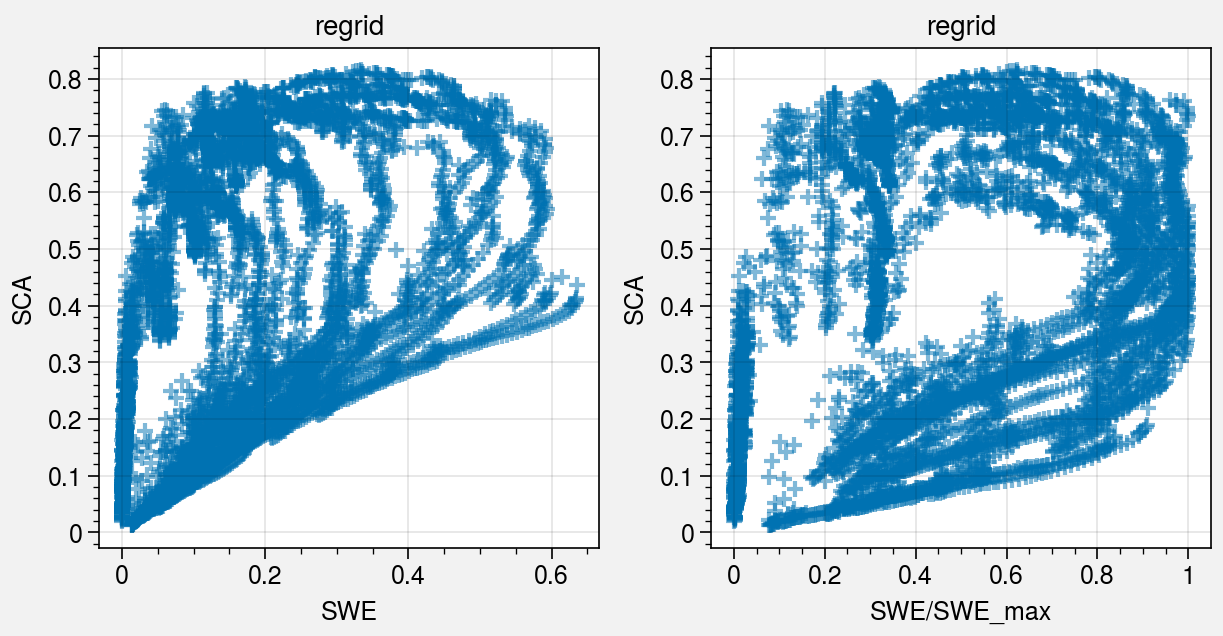

In [21]:
fig, axs = plot.subplots(ncols=2, nrows=1, share=0)

axs[0].scatter(swe_regrid.values.flatten(), sca_regrid.values.flatten(), marker='+', alpha=0.5)
axs[0].format(xlabel='SWE', ylabel='SCA', title='regrid')

axs[1].scatter((swe_regrid/swe_regrid.max('Day')).values.flatten(), sca_regrid.values.flatten(), marker='+', alpha=0.5)
axs[1].format(xlabel='SWE/SWE_max', ylabel='SCA', title='regrid')

### Check elevation

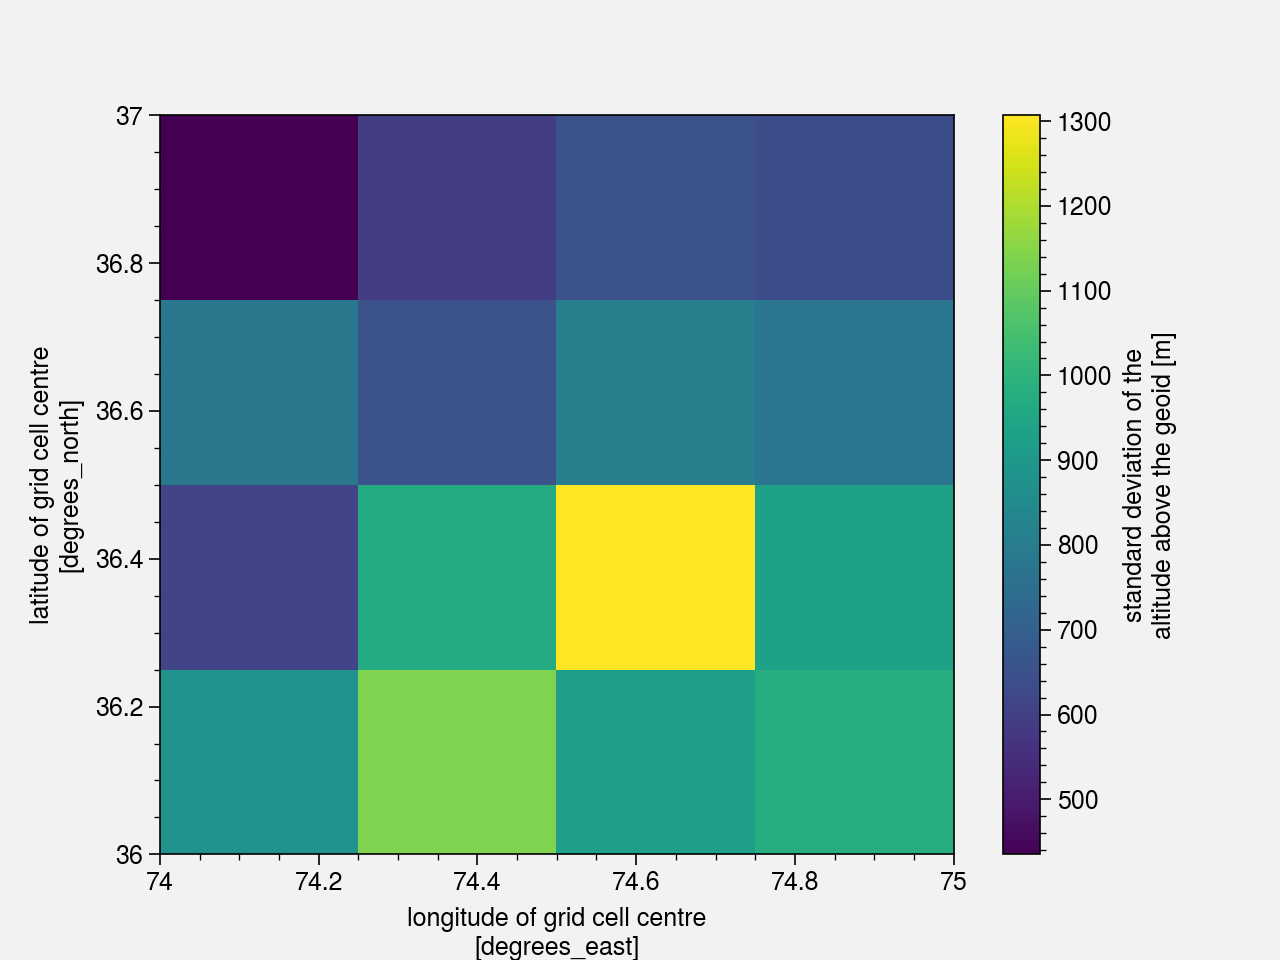

In [73]:
elevation_std.sel(lon=slice(sd.lon.min(),sd.lon.max()), lat=slice(sd.lat.min(),sd.lat.max())).plot()

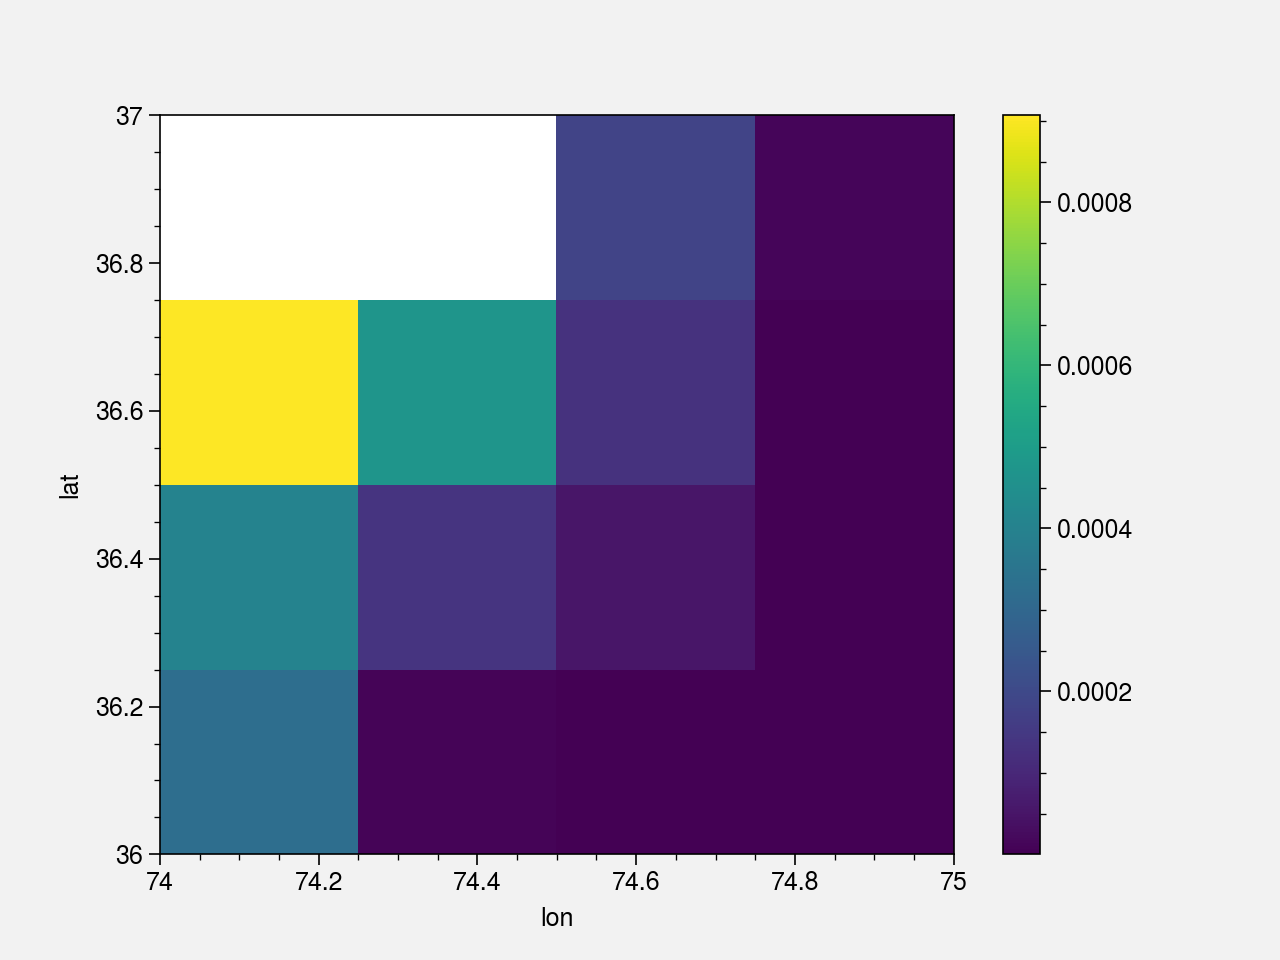

In [74]:
swe_regrid.where(elevation_std > 600)[0].plot()

In [82]:
swe_regrid[0][0][0]

<xarray.DataArray ()>
array(0.00032423)
Coordinates:
    lon      float32 74.125
    lat      float32 36.125
Attributes:
    regrid_method:  bilinear

In [22]:
swe_accu = []
sca_accu = []

swe_depl = []
sca_depl = []

for day in range(366-1):
    if swe_regrid[day][0][0] < swe_regrid[day+1][0][0]:
        swe_accu.append(swe_regrid[day+1][0][0])
        sca_accu.append(sca_regrid[day+1][0][0])
    else:
        swe_depl.append(swe_regrid[day+1][0][0])
        sca_depl.append(sca_regrid[day+1][0][0])

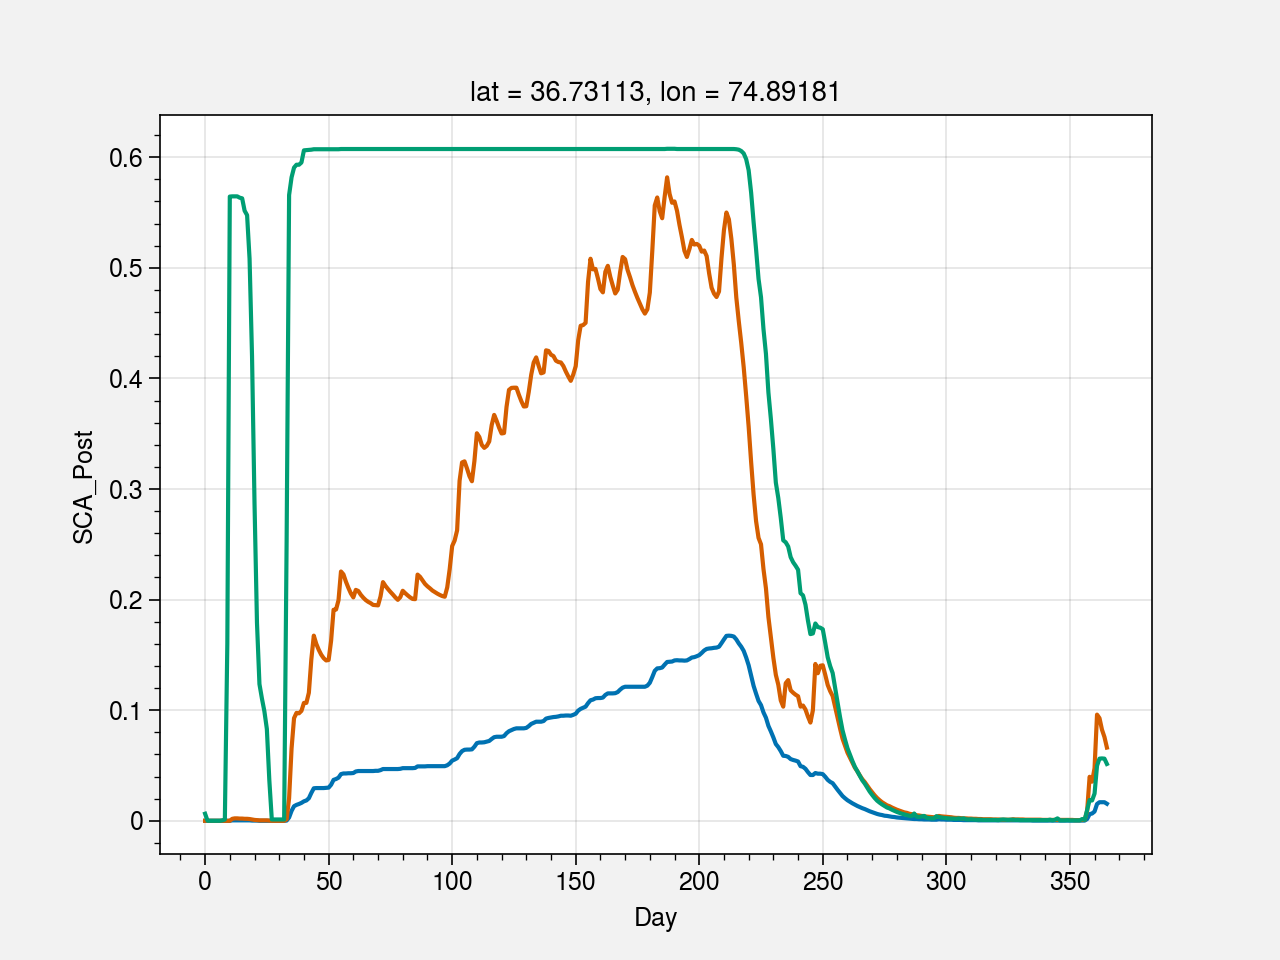

In [50]:
swe.isel(lat=60, lon=200).plot()
sd.isel(lat=60, lon=200).plot()
sca.isel(lat=60, lon=200).plot()

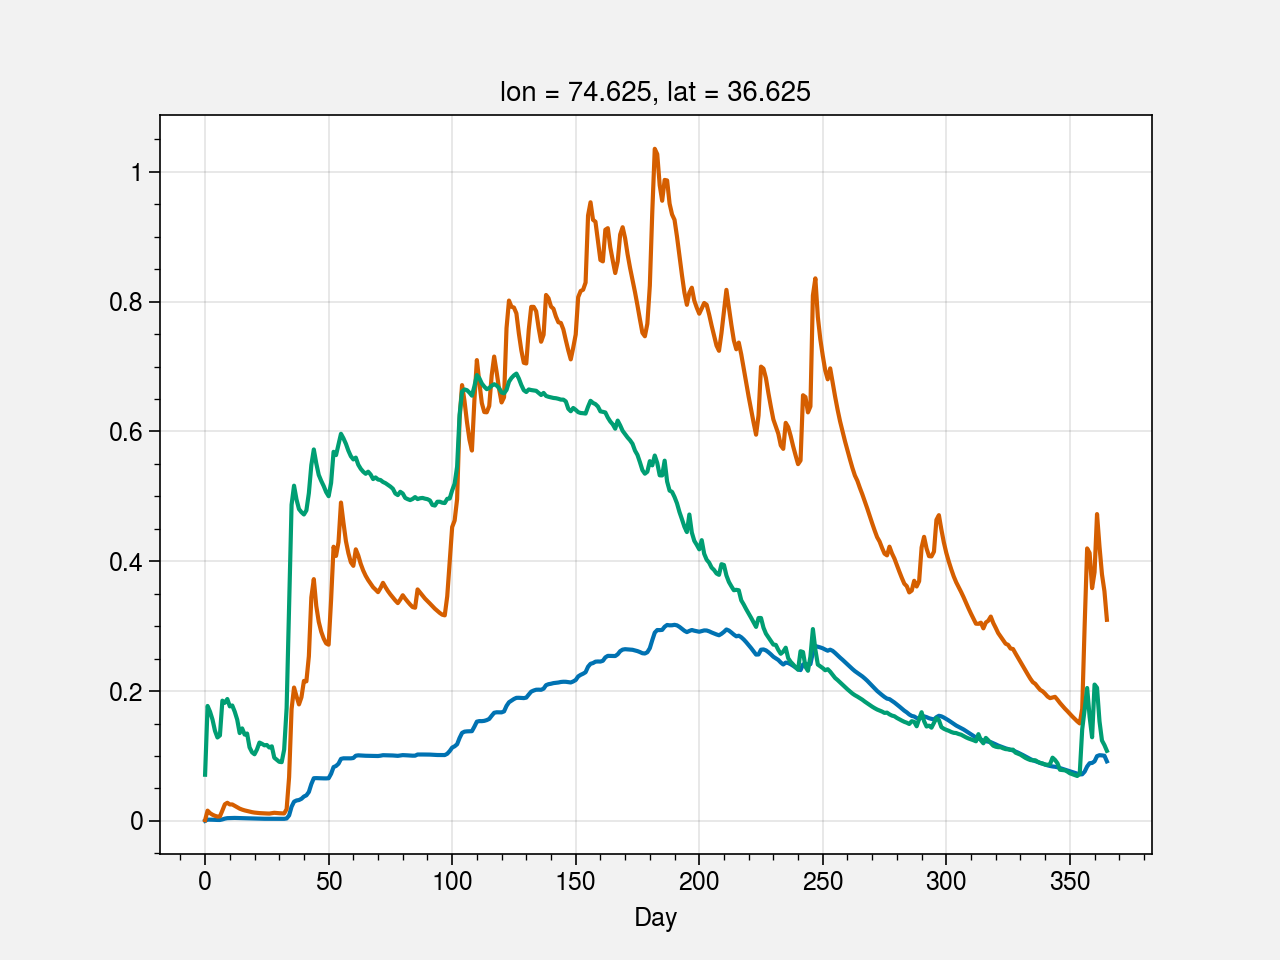

In [44]:
swe_regrid.isel(lat=2, lon=2).plot()
sd_regrid.isel(lat=2, lon=2).plot()
sca_regrid.isel(lat=2, lon=2).plot()

In [32]:
swe_accu = []
sca_accu = []

swe_depl = []
sca_depl = []

for i in range(4):
    for j in range(4):
        for day in range(366-1):
            if swe_regrid[day][i][j] < swe_regrid[day+1][i][j]:
                swe_accu.append(swe_regrid[day+1][i][j])
                sca_accu.append(sca_regrid[day+1][i][j])
            else:
                swe_depl.append(swe_regrid[day+1][i][j])
                sca_depl.append(sca_regrid[day+1][i][j])

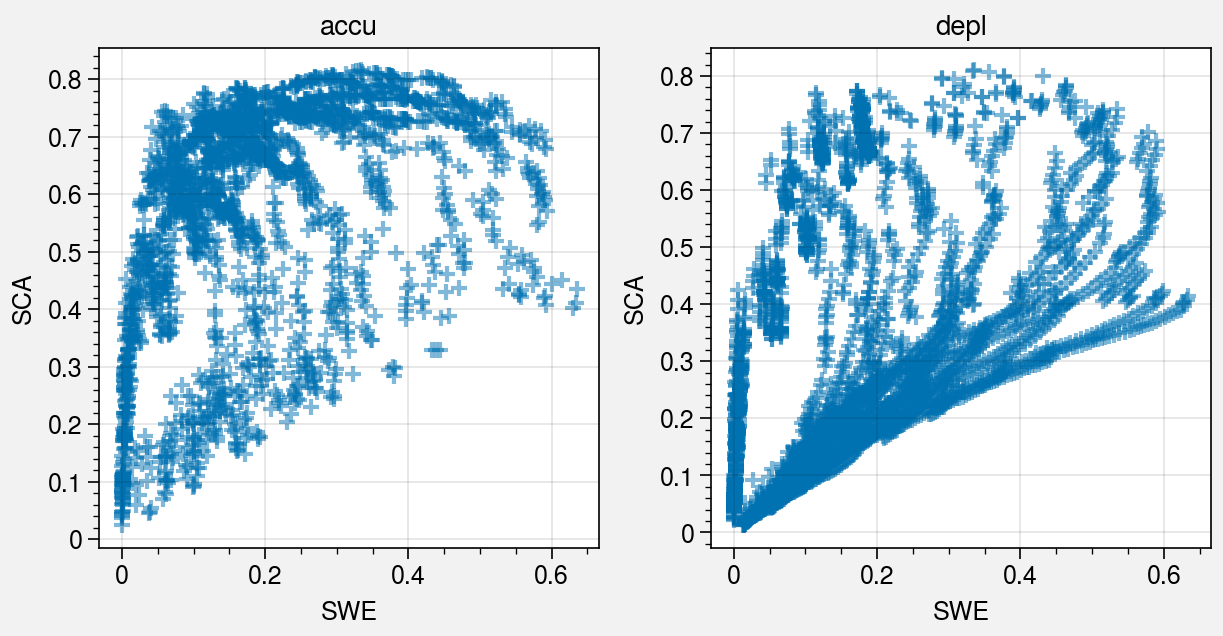

In [35]:
fig, axs = plot.subplots(ncols=2, nrows=1, share=0)

axs[0].scatter(swe_accu, sca_accu, marker='+', alpha=0.5)
axs[0].format(xlabel='SWE', ylabel='SCA', title='accu')

axs[1].scatter(swe_depl, sca_depl, marker='+', alpha=0.5)
axs[1].format(xlabel='SWE', ylabel='SCA', title='depl')

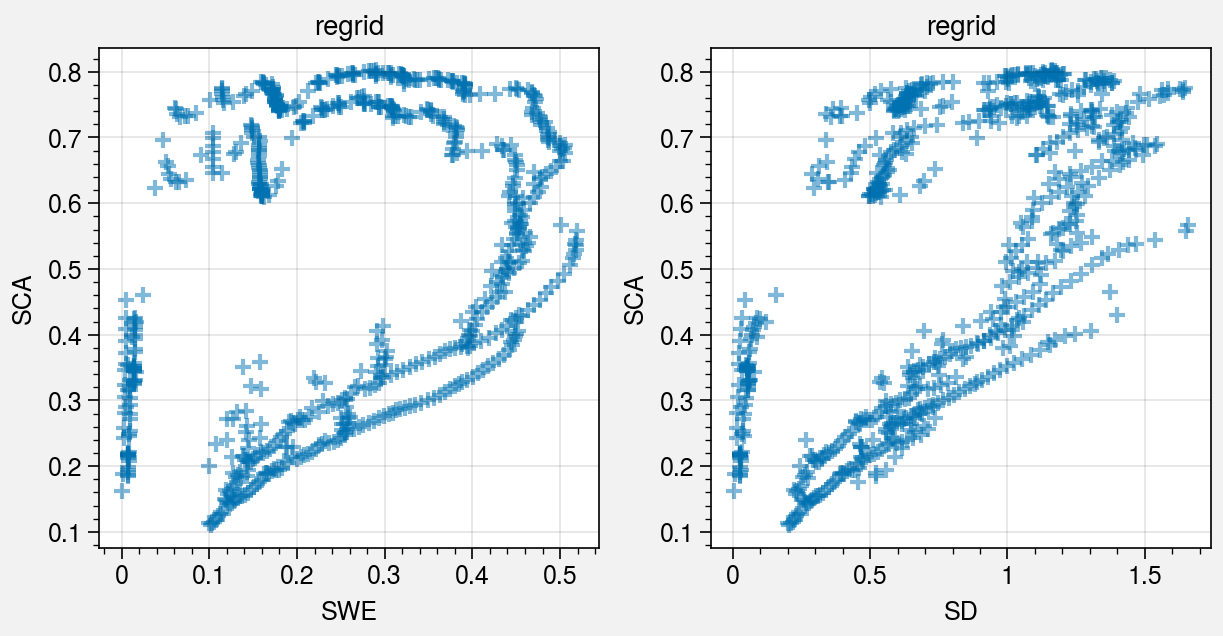

In [79]:
fig, axs = plot.subplots(ncols=2, nrows=1, share=0)

axs[0].scatter(swe_regrid.where(elevation_std < 600).values.flatten(), sca_regrid.values.flatten(), marker='+', alpha=0.5)
axs[0].format(xlabel='SWE', ylabel='SCA', title='regrid')

axs[1].scatter(sd_regrid.where(elevation_std < 600).values.flatten(), sca_regrid.values.flatten(), marker='+', alpha=0.5)
axs[1].format(xlabel='SD', ylabel='SCA', title='regrid')